<a href="https://colab.research.google.com/github/Gun-mIn/2020DA_CapstoneProject/blob/main/Frame_by_frame_Emotion_Classification_and_Emojify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toonify frame by frame

*  구글 드라이브와 연동합니다.
*  Tensorflow version 1.x를 선택합니다. (StyleGAN2는 TF1을 지원합니다.)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%cd /content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/

/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2


In [ ]:
%cd /content
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!mkdir raw
!mkdir generated
!mkdir aligned

/content
Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 4.51 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/stylegan2


*  Toonify 모델을 다운로드 받습니다.
*  StyleGAN2를 이용해 Disney, Pixar 캐릭터의 얼굴을 학습시켰습니다.

In [ ]:
!gdown https://drive.google.com/uc?id=19JFHU7RLJVWvQE1ohmkGsxnckM59H1Ez -O /content/drive/MyDrive/new/5.\ classification-and-emojify/stylegan2/toonify-model.pkl

Downloading...
From: https://drive.google.com/uc?id=19JFHU7RLJVWvQE1ohmkGsxnckM59H1Ez
To: /content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/toonify-model.pkl
382MB [00:02, 137MB/s]


*  Projection을 위해 network 변수에 각각의 모델들을 넣어 줍니다.

In [ ]:
import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/toonify-model.pkl" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

*  원본 영상을 가져와 10 프레임별로 이미지를 저장합니다.
*  stylegan2 폴더와 origin frame 폴더에 넣어줍니다.
*  stylegan2 폴더에 넣은 프레임 이미지를 이용하여 projection을 진행할 겁니다.

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import imutils
import cv2
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path


videofile = "sample-video"
video = cv2.VideoCapture('/content/drive/MyDrive/new/5. classification-and-emojify/video/{}.mp4'.format(videofile))
frame_count = 0

while video.isOpened():
    ret, frame = video.read()

    if not ret:
      video.release()
      break
    
    if frame_count % 10 == 0:
      # 영상이 뒤집어져 있어 회전을 해주었습니다.
      frame =  cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
      cv2.imwrite("/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/raw3/{}.png".format(frame_count),frame)
      cv2.imwrite("/content/drive/MyDrive/new/5. classification-and-emojify/frame/origin-frame/{}.png".format(frame_count),frame)
      frame_count += 1
    
    else:
      frame_count += 1

*  원본 영상의 프레임으로 원본 영상을 만들어줍니다.
*  굳이 원본 영상을 다시 만드는 이유는, 프레임별로 이미지를 받아와 영상을 제작한 stylegan2 적용 영상과 비교하기 위해서입니다.

In [ ]:
import imutils
import cv2
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
import glob
import os

img_arr1 = []
size1 = (0, 0)
frame_count = 0
frame_count += 1

latents = glob.glob("/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/raw3/*.jpg")
latents = os.listdir('/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/raw3')
latents = sorted(latents,key=lambda x: int(os.path.splitext(x)[0]))
print(latents)

for latent_file in latents:
  latent_file = "/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/raw3/{}".format(latent_file)
  origin_img = cv2.imread(latent_file)
  print(latent_file)
  height, width, layers = origin_img.shape
  size1 = (width, height)
  print(latent_file)
  img_arr1.append(origin_img)
  frame_count += 1


out1 = cv2.VideoWriter("/content/drive/MyDrive/new/5. classification-and-emojify/video/origin-video.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 3, size1)
for i in range(len(img_arr1)):
  out1.write(img_arr1[i])

out1.release()

*  StyleGAN2의 기본 모듈인 face detection과 align image를 사용해 원본 영상의 얼굴 부분을 crop하고, 정렬합니다.
*  project_images.py로 toonify된 이미지를 저장합니다.

In [ ]:
%cd /content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/

/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2


In [ ]:
!python align_images.py raw3 aligned3

64045056/64040097 [==============================] - 3s 0us/step


In [ ]:
!python project_images.py --num-steps 500 aligned3 generated3

In [ ]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path
import re

latent_dir = Path("/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/generated3")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  filename = re.findall("\d+", latent_file.stem)
  filename = filename[0]
  print(filename)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save("/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/generated3/{}.jpg".format(filename))
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save("/content/drive/MyDrive/new/5. classification-and-emojify/frame/toonify-frame/{}.jpg".format(filename))

*  만들어진 toonify 이미지를 다시 mp4 영상으로 만들어줍니다.
*  원본 영상의 **10 프레임** 마다 한 장씩 이미지를 받아와 projection을 하고, **FPS 3** 으로 영상을 만들었습니다.

In [ ]:
import imutils
import cv2
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
import glob
import os

img_arr1 = []
size1 = (0, 0)
frame_count = 0
frame_count += 1

latents = os.listdir('/content/drive/MyDrive/new/5. classification-and-emojify/frame/toonify-frame/')
latents = sorted(latents,key=lambda x: int(os.path.splitext(x)[0]))
print(latents)

for latent_file in latents:
  latent_file = "/content/drive/MyDrive/new/5. classification-and-emojify/stylegan2/generated3/{}".format(latent_file)
  emojify_img = cv2.imread(latent_file)
  height, width, layers = emojify_img.shape
  size1 = (width, height)
  print(latent_file)
  img_arr1.append(emojify_img)
  frame_count += 1


out1 = cv2.VideoWriter("/content/drive/MyDrive/new/5. classification-and-emojify/video/toonify-video.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 3, size1)
for i in range(len(img_arr1)):
  out1.write(img_arr1[i])

out1.release()

# Emotione Recognition
*  앞서 만들어진 Toonify 영상을 가져와 감정 인식을 진행합니다.
*  아래의 코드는 실시간 영상에 대해서도 적용 가능하니, 실시간 감정 인식을 원하신다면 video capture 기능을 사용해 수정하시길 바랍니다.
*  StyleGAN2와는 달리 TF2를 지원합니다. TF1을 앞서 설정해두었다면 런타임을 다시 시작해야 합니다.
*  다시 런타임을 실행하고 구글 드라이브와 연동해줍니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x

*  OpenCV에서 제공하는 얼굴 탐지 모듈을 사용할 겁니다.
*  아래에서 frontal face default 파일을 다운 받아 줍시다. (구글 드라이브에 저장해서 사용하는 경우, 알 수 없는 에러가 발생합니다. 런타임 실행시 다운 받아 사용하고, 런타임 종료시 제거되도록 합시다)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O /content/haarcascade_frontalface_default.xml

--2020-12-16 11:00:23--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘/content/haarcascade_frontalface_default.xml’

/content/haarcascad 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2020-12-16 11:00:23 (39.9 MB/s) - ‘/content/haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
%cd /content

/content


Populating the interactive namespace from numpy and matplotlib


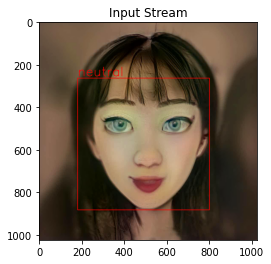

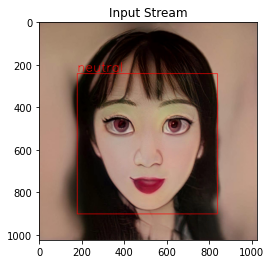

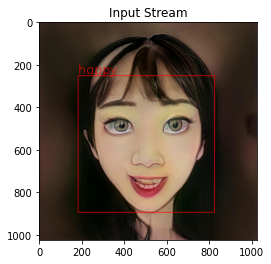

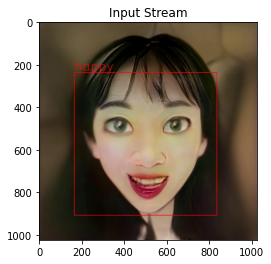

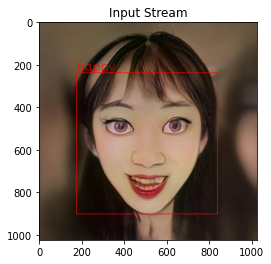

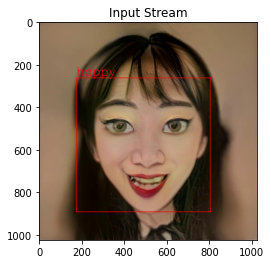

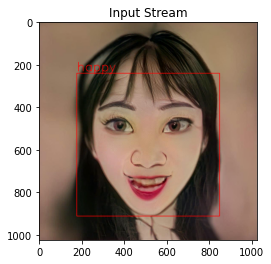

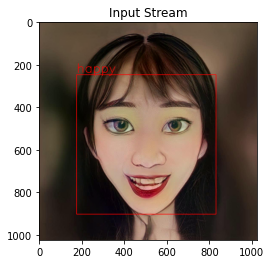

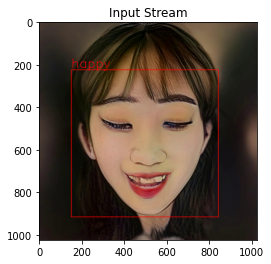

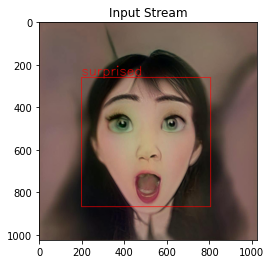

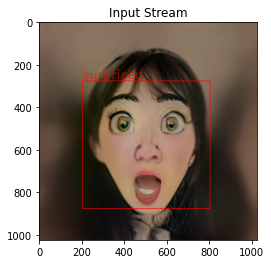

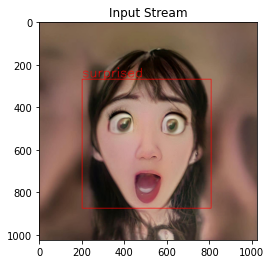

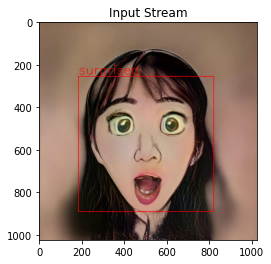

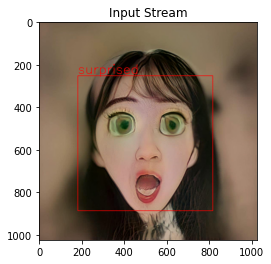

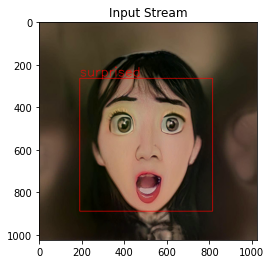

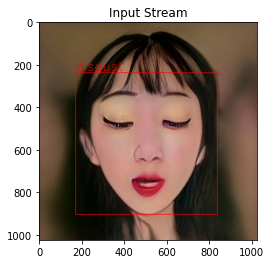

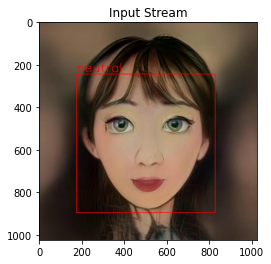

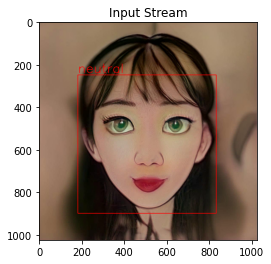

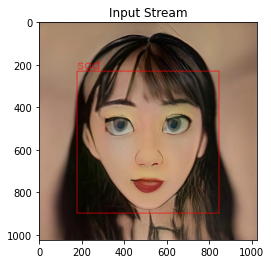

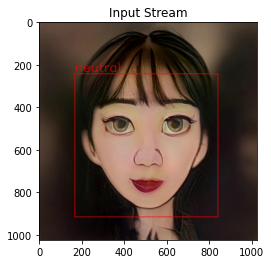

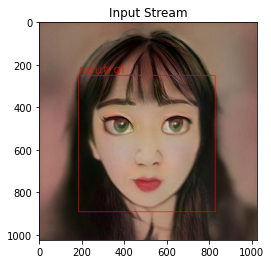

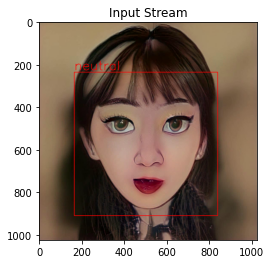

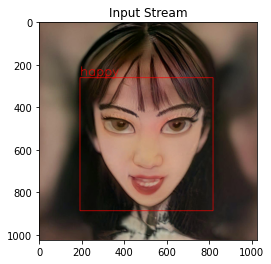

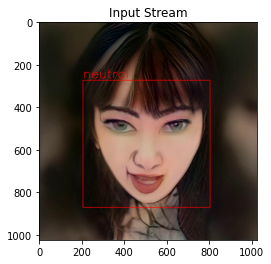

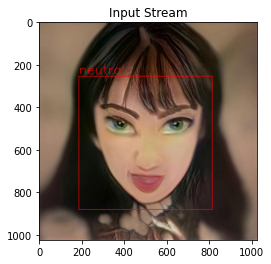

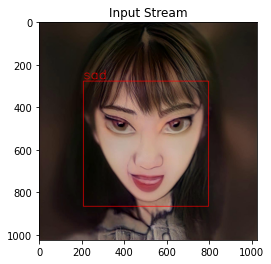

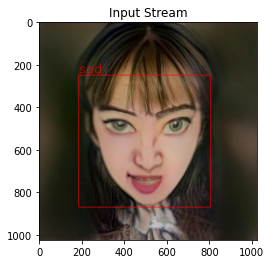

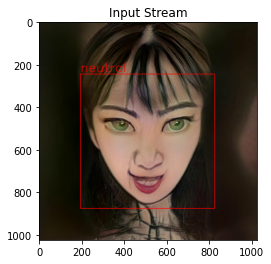

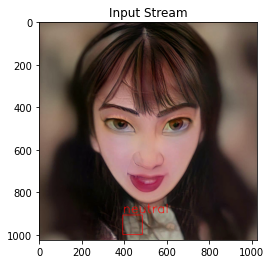

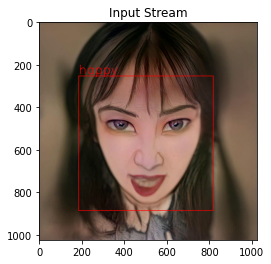

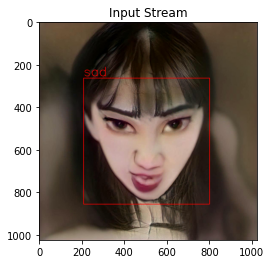

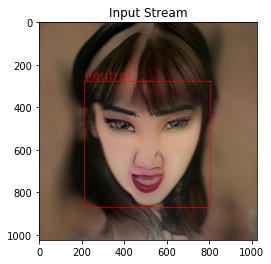

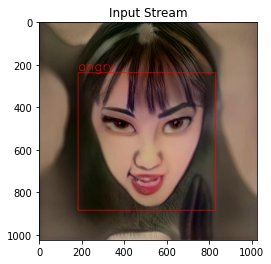

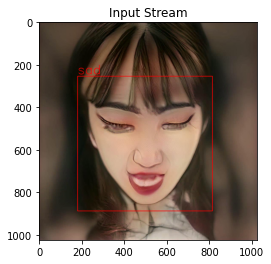

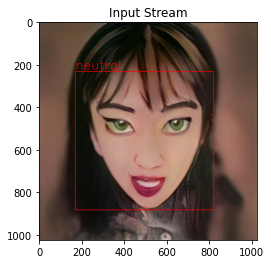

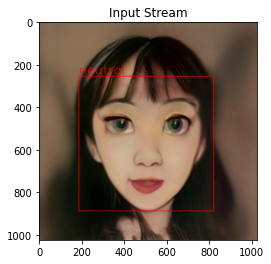

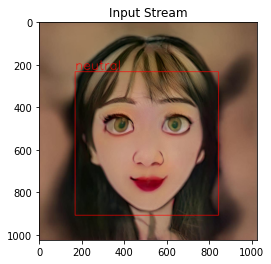

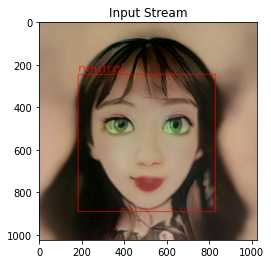

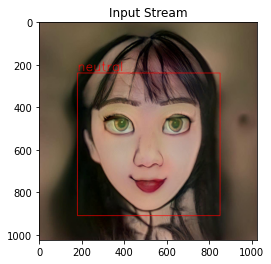

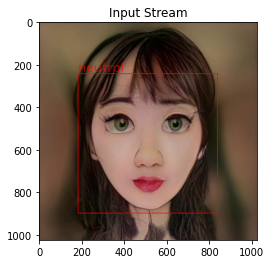

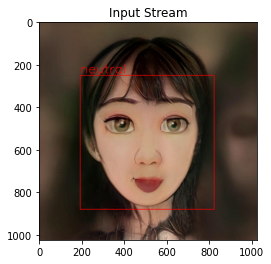

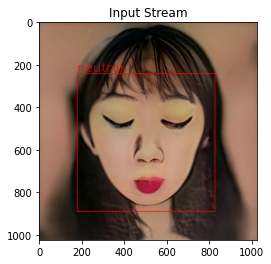

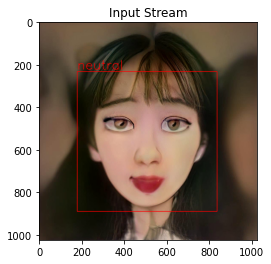

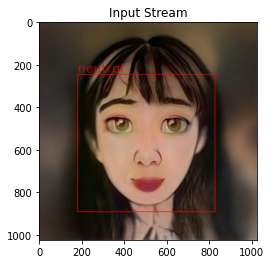

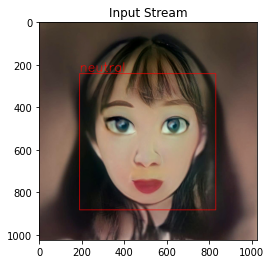

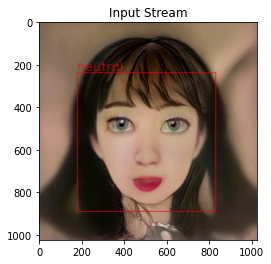

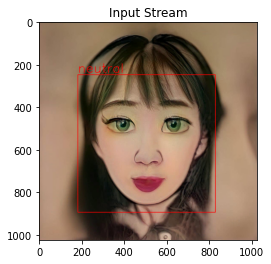

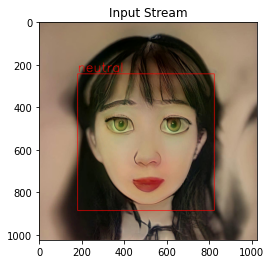

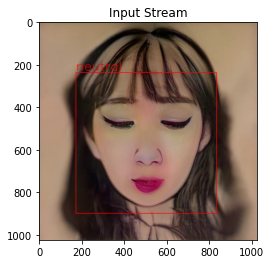

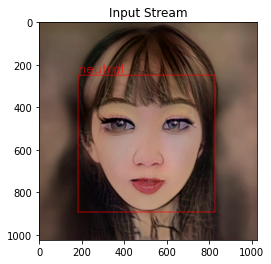

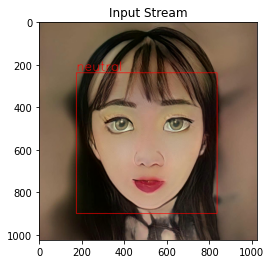

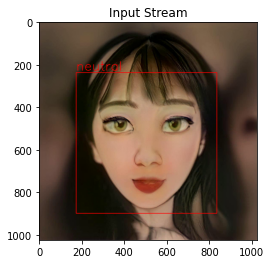

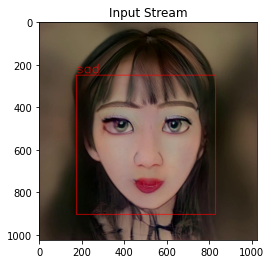

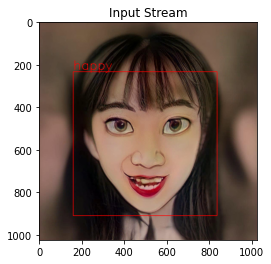

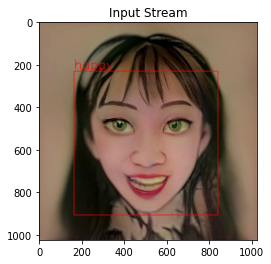

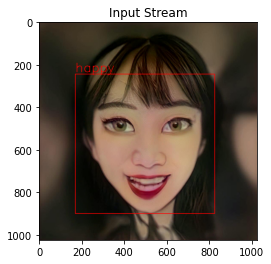

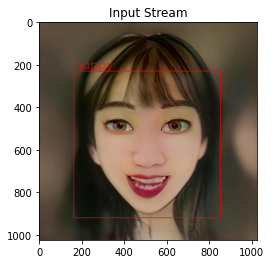

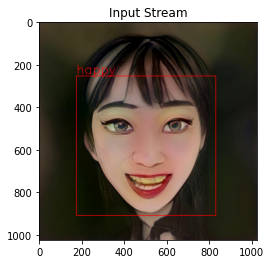

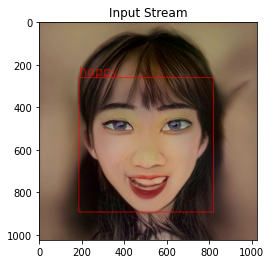

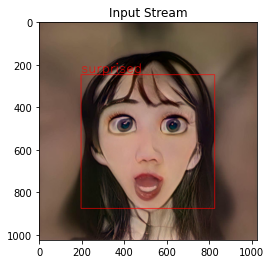

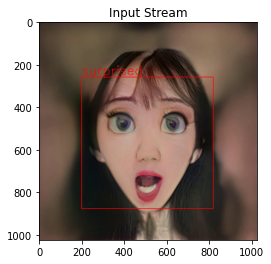

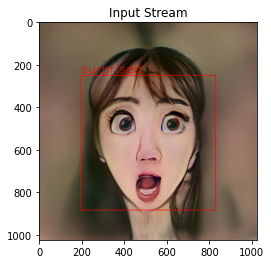

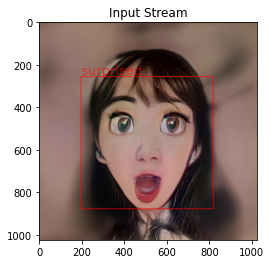

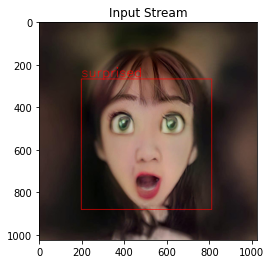

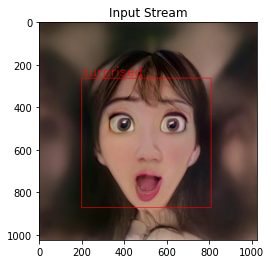

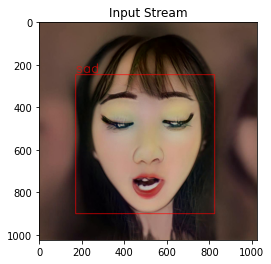

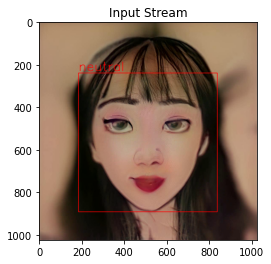

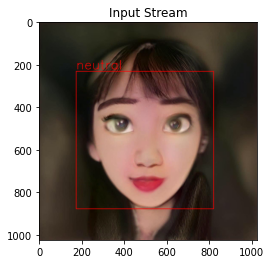

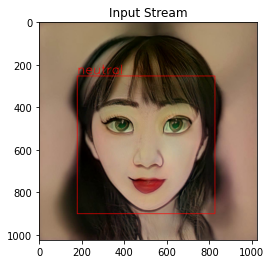

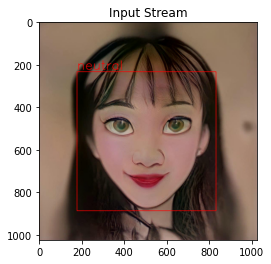

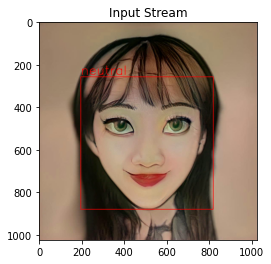

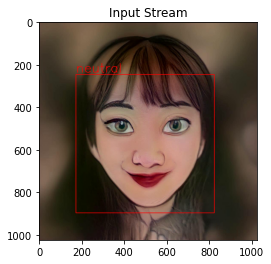

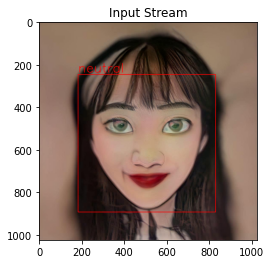

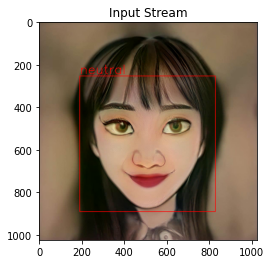

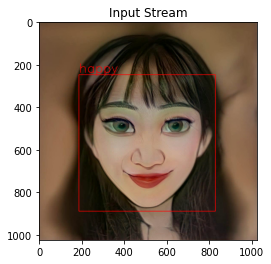

75


In [ ]:
%pylab inline 
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from keras.preprocessing.image import img_to_array
import imutils
import cv2

from tensorflow.keras.models import load_model
import numpy as np


# parameters for loading data and images
detection_model_path = 'haarcascade_frontalface_default.xml'
emotion_model_path = '/content/drive/MyDrive/new/5. classification-and-emojify/models/model9.hdf5'

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path)
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised", "neutral"]


img_arr = []
size = (0, 0)
frame_count = 0

# starting video streaming
#cv2.namedWindow('your_face')
camera = cv2.VideoCapture('/content/drive/MyDrive/new/5. classification-and-emojify/video/toonify-video.mp4')
while True:
    ret, frame = camera.read()

    if not ret:
      camera.release()
      break

    frame_count += 1

    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)

    frameClone = frame.copy()
    if len(faces) > 0:
        faces = sorted(faces, reverse=True,
        key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
        (fX, fY, fW, fH) = faces
        
        face_img = frame[fY:fY + fH, fX:fX + fW]

        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (96, 96)) #original - 48, 48
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        preds = emotion_classifier.predict(roi)[0]

        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]

        for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
          # construct the label text
          cv2.putText(frameClone, label, (fX, fY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
          cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
                      (0, 0, 255), 2)


        frameClone = cv2.resize(frameClone, (1024, 1024))
        cv2.imwrite("/content/drive/MyDrive/new/5. classification-and-emojify/frame/emotion-recognition/{}.png".format(frame_count),frameClone)
        height, width, layers = frameClone.shape
        size = (width, height)
        img_arr.append(frameClone)

        frameClone = cv2.cvtColor(frameClone, cv2.COLOR_BGR2RGB)
        title("Input Stream")
        plt.imshow(frameClone)
        plt.show() 

    else: 
      font = cv2.FONT_HERSHEY_DUPLEX
      cv2.putText(frame, "Cannot Detect Face Region", (80, 1000), font, 2, (0,0,155), 2, cv2.LINE_AA)

      frame = cv2.resize(frame, (1024, 1024))
      cv2.imwrite("/content/drive/MyDrive/new/5. classification-and-emojify/frame/emotion-recognition/{}.png".format(frame_count),frame)
      height, width, layers = frameClone.shape
      size = (width, height)
      img_arr.append(frameClone)

      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      title("Input Stream")
      plt.imshow(frame)
      plt.show()

out = cv2.VideoWriter("/content/drive/MyDrive/new/5. classification-and-emojify/video/emotion-recognition-video.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 3, size)
print(len(img_arr))
for i in range(len(img_arr)):
  out.write(img_arr[i])

out.release()